In [148]:
# import relevant modules 
import os
import sys
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

# locate directory containing scripts 
current_directory = os.getcwd() 
src_directory = os.path.dirname(current_directory) + '/src'
sys.path.append(src_directory)

# import custom modules
import spin_chain
import simulate_algorithm

# reload custom modules
reload(spin_chain)
reload(simulate_algorithm)

# import functions from modules
from spin_chain import symmetry_eigvecs, properties
from simulate_algorithm import generate_initial_states, format_number, plot_exact_fidelity

In [149]:
# specify parameters for spin chain (number of sites, coupling constants, 
# periodic or nonperiodic boundary conditions,  and tolerance 
# with which to determine orthonormality of eigenstates
N = 4
Jx = 1
Jy = 1
Jz = 1
periodic_bc = True
tolerance4 = 1e-12

# collect properties of spin chain
H4, H4_list, eigenstates4, eigenvalues4, E_0, ρ_ground_state4 = \
    properties(N, Jx, Jy, Jz, periodic_bc, tolerance4)

In [224]:
# define parameters for simulations
N_cavities = 4
N_qubits = 4
α_start = 0
α_end = 1
α_steps = 100
m_start = 4
m_stop = 4
Es = -8
num_states = 1
tolerance = tolerance4
cutoff = 'N/A'
save_file = False

Ψ0_list, ψ0_list = generate_initial_states(N_cavities, N_qubits, num_states, cutoff)

# compute symmetry eigevectors 
P, eigvecs, ρ_list = symmetry_eigvecs(N_qubits, Jx, Jy, Jz, periodic_bc)

# isolate first initial state
ψ0 = ψ0_list[0]

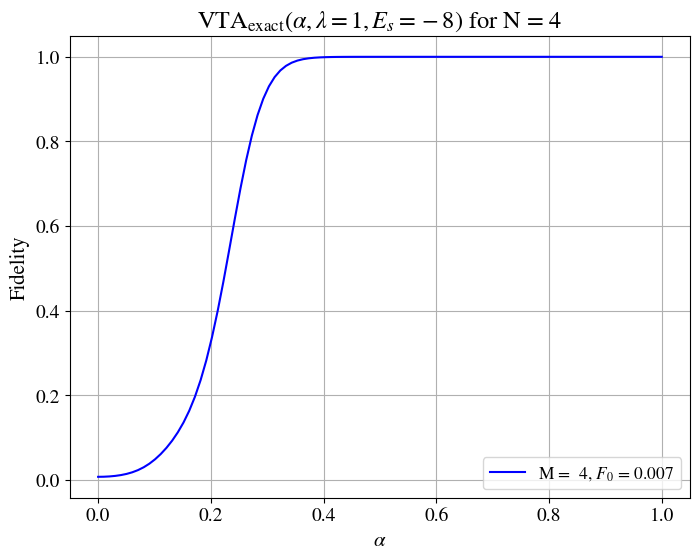

In [194]:
Es = -8
VTA_exact_fidelity_array = plot_exact_fidelity(N_cavities, α_start, α_end, α_steps, Es, m_start, m_stop, 
                                       N_qubits, Jx, Jy, Jz, periodic_bc, tolerance, ψ0_list, save_file)

# $\text{VTA}_{\text{exact}}(\alpha, \lambda, E_{s})$

In [275]:
# G(α, Es) basis functions
e0 = lambda α, Es: np.exp(-2*(α**2)*((Es + 12)**2)) 
e1 = lambda α, Es: np.exp(-2*(α**2)*((Es + 8)**2)) 
e2 = lambda α, Es: np.exp(-2*(α**2)*((Es + 4)**2)) 
e3 = lambda α, Es: np.exp(-2*(α**2)*(Es**2)) 
e4 = lambda α, Es: np.exp(-2*(α**2)*((Es - 4)**2))
e5 = lambda α, Es: np.exp(-2*(α**2)*((Es + 2)**2 + 4))
e6 = lambda α, Es: np.exp(-2*(α**2)*((Es + 2)**2 + 20))
e7 = lambda α, Es: np.exp(-2*(α**2)*(Es**2 + 8))
e8 = lambda α, Es: np.exp(-2*(α**2)*((Es + 4)**2 + 16))
e9 = lambda α, Es: np.exp(-2*(α**2)*(Es**2 + 16))
e10= lambda α, Es: np.exp(-2*(α**2)*((Es + 4)**2 + 32))

# G(α, Es) coefficients
g00 = lambda α, Es: (3*e0(α, Es) + 24*e1(α, Es) \
                     + 6*e2(α, Es) - e4(α, Es))/32
g44 = lambda α, Es: -(e0(α, Es) - 6*e2(α, Es) \
                      - 24*e3(α, Es) - 3*e4(α, Es))/32
g04 = lambda α, Es: (np.sqrt(3)*(e0(α, Es) + 4*e1(α, Es) - \
                     10*e2(α, Es) + 4*e3(α, Es) + e4(α, Es)))/32
g40 = lambda α, Es: - g04(α, Es)
gt = lambda α, Es: (e10(α, Es) + e2(α, Es) + 4*e5(α, Es) - 4*e6(α, Es) + \
                    2*e8(α, Es))/4
gs = lambda α, Es: (e3(α, Es) + e5(α, Es) - e6(α, Es) + e9(α, Es))/2
gq = lambda α, Es: e4(α, Es)

In [271]:
def VTA_exact(ψ, ρ_ground_stateN, α, Es, r): 

    '''
    compute single VTA_exact for a given α, Es, and r
    '''
    
    # analytic expression for the coefficients of F(α; Es)
    f = lambda x, α: np.exp(-32*(α**2)*(x - 1 - Es/4)**2)

    # compute F
    F = (f(-1, α)*ρ_list[0] + \
         f(0, α)*sum(ρ_list[1:3 + 1]) + \
         f(1, α)*sum(ρ_list[4:10 + 1]) + \
         f(2, α)*sum(ρ_list[11:15 + 1])).tidyup(atol = tolerance)
    
    # iterate algorithm r times 
    for _ in range(r):
        ψ = (F*ψ).unit()

    # return projection fidelity of algorithm 
    return expect(ρ_ground_stateN, ψ)
def F_explicit(ψ, ρ_ground_stateN, α, Es, r): 
    
    '''
    compute VTA_exact using explicitly defined VTA_exact
    '''
    # define F_explicit
    return (((-(α**2)/2)*(H4 - Es)**2).expm()).tidyup(atol = tolerance)
def VTA(ψ, ρ_ground_stateN, α, Es, r): 

    '''
    compute single VTA for a given α, Es, and r
    '''

    # define operator that acts on the logical qubit subspace
    GL_op = lambda α, Es: g00(α, Es)*ρ_list[0] + \
                          g04(α, Es)*eigvecs[0]*eigvecs[4].dag() + \
                          g40(α, Es)*eigvecs[4]*eigvecs[0].dag() + \
                          g44(α, Es)*ρ_list[4]

    # compute G
    G = (GL_op(α, Es) + \
        gt(α, Es)*sum(ρ_list[1:4]) + \
        gs(α, Es)*sum(ρ_list[5:11]) + \
        gq(α, Es)*sum(ρ_list[11:16])).tidyup(atol = tolerance)
    
    # iterate algorithm r times 
    for _ in range(r):
        ψ = (G*ψ).unit()

    # return projection fidelity of algorithm 
    return expect(ρ_ground_stateN, ψ)
def plot_heatmap(VTA_type, ψ0, α_start, α_end, α_steps, Es_start, Es_end, Es_steps, r_start, r_end): 
    
    '''
    plots heatmap for sweep over α vs Es or r
    '''
    
    # calculate initial fidelity
    F0 = expect(ρ_ground_state4, ψ0)
    
    # examine parameters for Es sweep and r sweep
    Es_params = len(set([Es_start, Es_end]))
    r_params = len(set([r_start, r_end]))
    
    if Es_params != 1 and r_params == 1: 
        
        # define r value
        r = r_start

        # construct α_array and Es_array
        α_array = np.linspace(α_start, α_end, α_steps)
        Es_array = np.linspace(Es_start, Es_end, Es_steps)

        # create grids from α_array and Es_array
        α_grid, Es_grid = np.meshgrid(α_array, Es_array)

        # compute data for sweep over α and Es
        fidelity_values = np.zeros((len(Es_array), len(α_array)))
        
        # calculate projection fidelities using either VTA_exact or VTA
        if VTA_type == 'exact': 
        
            for i, Es, in enumerate(Es_array):
                for j, α in enumerate(α_array): 
                    fidelity_values[i, j] = VTA_exact(ψ0, ρ_ground_state4, α, Es, r)
                    
        elif VTA_type == 'approximate': 
            
            for i, Es, in enumerate(Es_array):
                for j, α in enumerate(α_array): 
                    fidelity_values[i, j] = VTA(ψ0, ρ_ground_state4, α, Es, r)
        else: 
            raise ValueError('Please enter valid VTA_type')
                
        # define window parameters for plot
        extent = [α_start, α_end, Es_start, Es_end]
        
        # define y axis
        ylabel_str = r'$E_s$'

        # define title string
        title_str = fr'$\mathrm{{VTA}}_{{\mathrm{{exact}}}}(\alpha, \lambda = {format_number(Jz/Jy)}, E_s)$ ' \
             fr'with r = {r} and $F_0 = {round(F0, 3)}$'
        
    elif r_params != 1 and Es_params == 1:
        
        # define Es value
        Es = Es_start

        # construct α_array and Es_array
        α_array = np.linspace(α_start, α_end, α_steps)
        r_array = list(range(r_start, r_end+1))

        # create grids from α_array and Es_array
        α_grid, r_grid = np.meshgrid(α_array, r_array)

        # compute data for sweep over α and Es
        fidelity_values = np.zeros((len(r_array), len(α_array)))
        
        # calculate projection fidelities using either VTA_exact or VTA
        if VTA_type == 'exact': 
        
            for i, Es, in enumerate(Es_array):
                for j, α in enumerate(α_array): 
                    fidelity_values[i, j] = VTA_exact(ψ0, ρ_ground_state4, α, Es, r)
                    
        elif VTA_type == 'approximate': 
            
            for i, Es, in enumerate(Es_array):
                for j, α in enumerate(α_array): 
                    fidelity_values[i, j] = VTA(ψ0, ρ_ground_state4, α, Es, r)
        else: 
            raise ValueError('Please enter valid VTA_type')
                
        # define window parameters for plot
        extent = [α_start, α_end, r_start, r_end]
        
        # define y axis
        ylabel_str = 'r'

        # define title string
        title_str = r'$\mathrm{{VTA}}_{{\mathrm{{exact}}}}(\alpha, ' \
                    + fr'\lambda = {format_number(Jz/Jy)}, E_s = {Es})$' \
                    +  fr' for $F_0 = {round(F0, 3)}$'
    
    else: 
        raise ValueError('Please enter valid parameters for sweep over Es or r')
        
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap
    cax = ax.imshow(fidelity_values, extent=extent, \
                    origin='lower', cmap='coolwarm', aspect='auto')

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax, label='Fidelity')

    # Set title and labels
    ax.set_xlabel('α')
    ax.set_ylabel(ylabel_str)
    ax.set_title(title_str)

    # display plot
    plt.show()

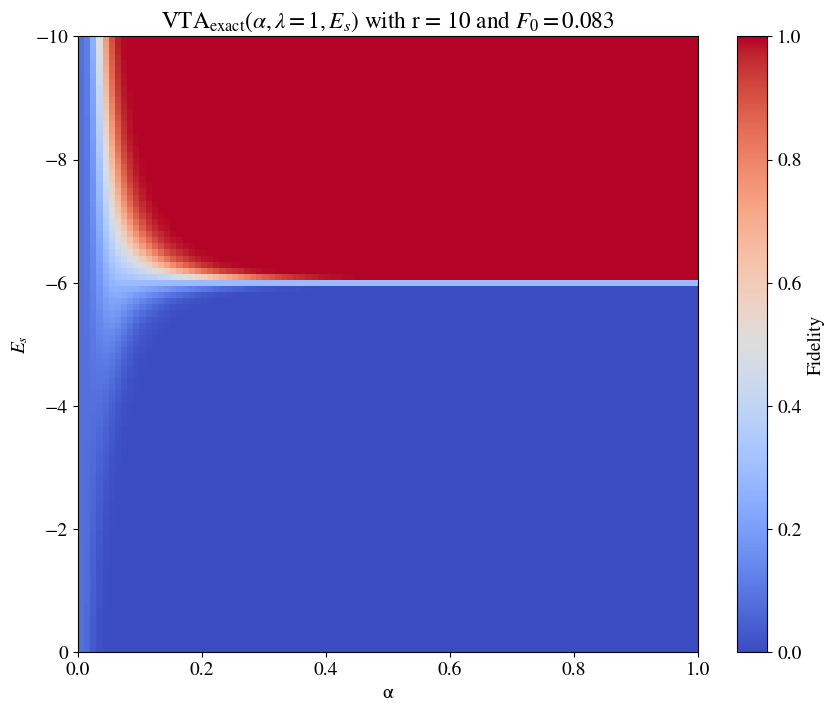

In [270]:
# specific VTA_exact or VTA
VTA_type = 'exact'

# parameters for α_array 
α_start = 0 
α_end = 1
α_steps = 101

# parameters for α_array 
Es_start = 0
Es_end = -10
Es_steps = 101

r_start = 10
r_end = 10

plot_heatmap(VTA_type, ψ0, α_start, α_end, α_steps, Es_start, Es_end, Es_steps, r_start, r_end)

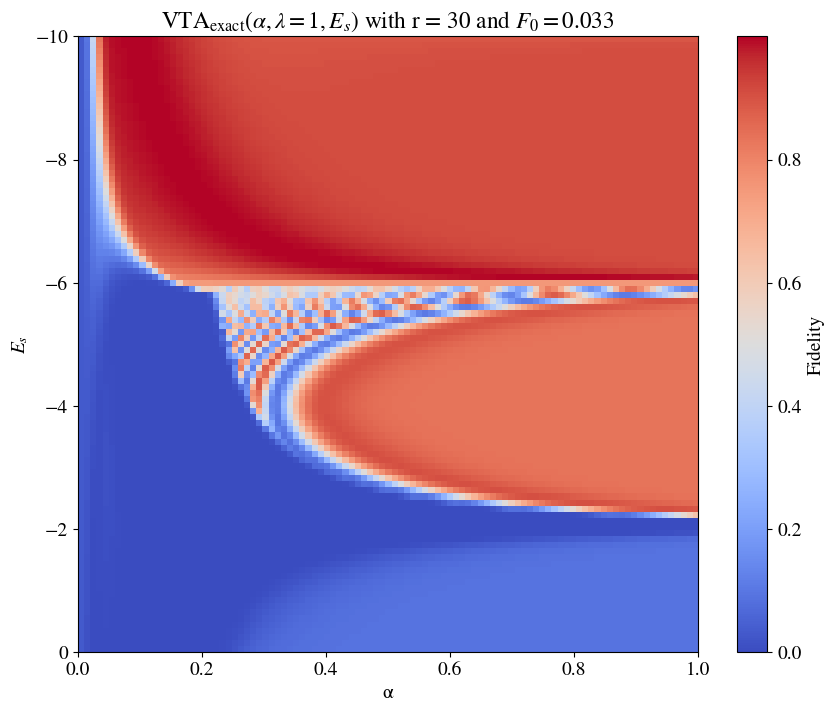

In [284]:
# specific VTA_exact or VTA
VTA_type = 'approximate'

# parameters for α_array 
α_start = 0 
α_end = 1
α_steps = 101

# parameters for α_array 
Es_start = 0
Es_end = -10
Es_steps = 101

r_start = 30
r_end = 30

plot_heatmap(VTA_type, ψ0, α_start, α_end, α_steps, Es_start, Es_end, Es_steps, r_start, r_end)